# Hotel booking

## Content:
### 1. EDA

The dataset contains data from two different hotels. One Resort hotel and one City hotel.

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) we know that both hotels are located in Portugal (southern Europe) ("H1 at the resort region of Algarve and H2 at the city of Lisbon"). The distance between these two locations is ca. 280 km by car and both locations border on the north atlantic.  

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".  
Note: For most questions I will only use bookings that were not canceled, to get acutal guest numbers. As you will see, this is quite a big difference.

Topics covered and questions to answer from the data:
- Where do the guests come from?
- How much do guests pay for a room per night?
- How does the price per night vary over the year?
- Which are the most busy month?
- How long do people stay at the hotels?
- Bookings by market segment
- How many bookings were canceled?
- Which month have the highest number of cancelations?

Do you have more questions? Tell me in the comments and I will see if I can answer them. :)


### 2. Predicting cancelations
It would be nice for the hotels to have a model to predict if a guest will actually come.  
This can help a hotel to plan things like personel and food requirements.  
Maybe some hotels also use such a model to offer more rooms than they have to make more money... who knows...

### 3. Evaluate Feature importance
Which features are most important to predict cancelations?  

Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [70]:
# common libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
!pip install folium
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
!pip install eli5
import eli5 # Feature importance evaluation



# load data:
file_path = "/Users/kshitijmahajan/Desktop/hotel_bookings.csv"
df = pd.read_csv(file_path)
df1=pd.read_csv(file_path)


In [71]:
# A bit of data inspection andleanup, I did most of the inspectin seperately
df
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = df.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [42]:
df['reservation_status']


0         Check-Out
1         Check-Out
2         Check-Out
3         Check-Out
4         Check-Out
            ...    
119385    Check-Out
119386    Check-Out
119387    Check-Out
119388    Check-Out
119389    Check-Out
Name: reservation_status, Length: 119390, dtype: object

In [72]:
# check for missing values
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [43]:
# filling null values with zero

df.fillna(0, inplace = True)

# adults, babies and children cant be zero at same time, so dropping the rows having all these zero at same time

filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df[filter]

df = df[~filter]
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [44]:
df['is_canceled'].value_counts()

0    75011
1    44199
Name: is_canceled, dtype: int64

In [45]:
# How much data is left?
df.shape

(119210, 32)

# 1. EDA

In [46]:
data_resort = df[(df['hotel'] == 'Resort Hotel') & (df['is_canceled'] == 0)]
data_city = df[(df['hotel'] == 'City Hotel') & (df['is_canceled'] == 0)]

## What is the distribution of resort hotel and city hotels?

Text(0, 0.5, 'Count')

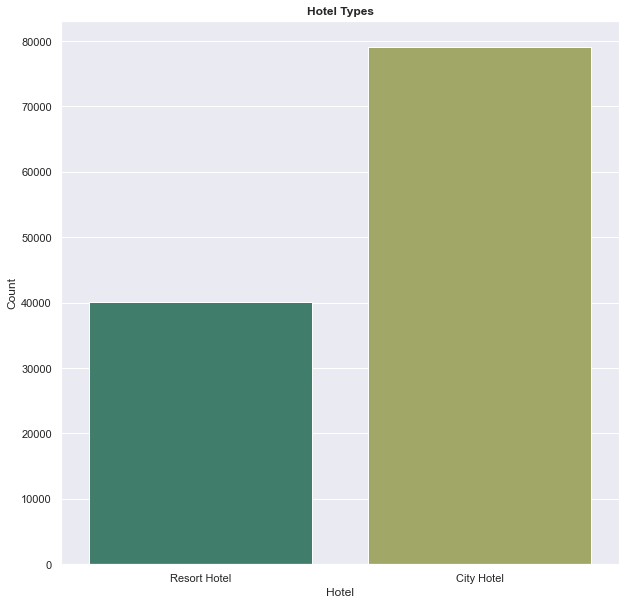

In [47]:
# Hotel types details
#First graph is about exploring hotel feature which denotes type of the hotels. 
#According to the below graph, approximately 34% of the data was booked for resort hotel and the rest of was booked for City Hotel.

plt.figure(figsize=(10,10))
sns.countplot(x='hotel', data = df, palette='gist_earth')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Count', fontsize=12)

## How many bookings were cancelled?

Text(0, 0.5, 'Canceled or Not Canceled')

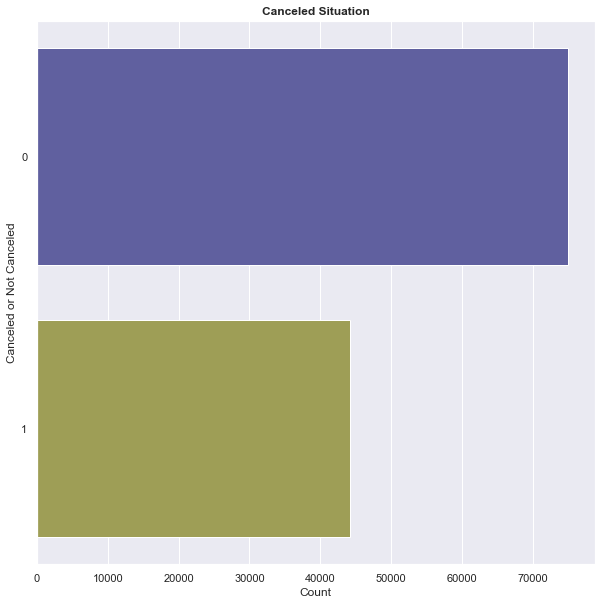

In [48]:
# `is_canceled` graph

plt.figure(figsize=(10,10))
sns.countplot(y='is_canceled', data= df, palette='gist_stern', orient = 'v')
plt.title('Canceled Situation', weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Canceled or Not Canceled', fontsize=12)

## Which month observes the highest customer arrival rate?

In [49]:
#`arrival_date_month` names converted to the numbers

df['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

Text(0, 0.5, 'Count')

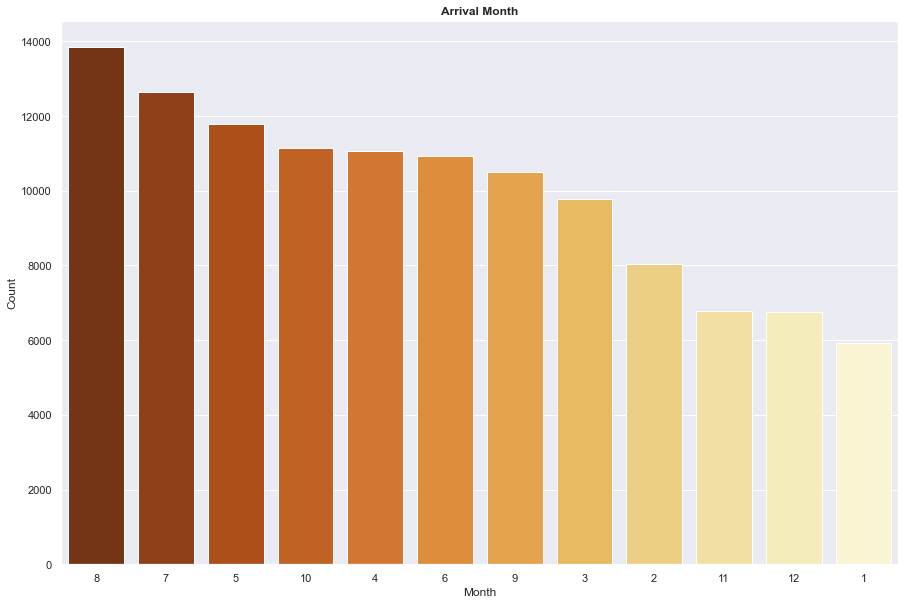

In [50]:
#`arrival_date_month` exploration 

plt.figure(figsize=(15,10))
sns.countplot(x='arrival_date_month', data = df,
              order=pd.value_counts(df['arrival_date_month']).index, palette='YlOrBr_r')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

### Where do the guests come from?

In [51]:
country_wise_guests = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']
country_wise_guests

,country,No of guests
0,PRT,20977
1,GBR,9668
2,FRA,8468
3,ESP,6383
4,DEU,6067
...,...,...
161,BHR,1
162,DJI,1
163,MLI,1
164,NPL,1


In [52]:
#show on map
basemap = folium.Map()
guests_map = px.choropleth(country_wise_guests, locations = country_wise_guests['country'],
                           color = country_wise_guests['No of guests'], hover_name = country_wise_guests['country'])
guests_map.show()

People from all over the world are staying in these two hotels. Most guests are understandably from Portugal and other European countries.

## Cancellations by repeated guests

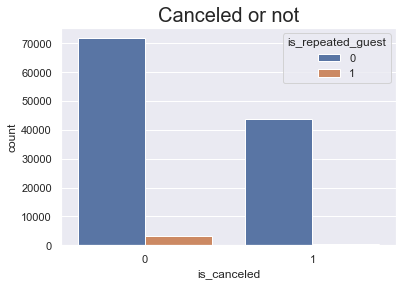

In [53]:
sns.set(style = "darkgrid")
plt.title("Canceled or not", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = df)

## How does the price vary per night over the year?

In [73]:
data_resort = df1[(df1['hotel'] == 'Resort Hotel') & (df1['is_canceled'] == 0)]
data_city = df1[(df1['hotel'] == 'City Hotel') & (df1['is_canceled'] == 0)]
resort_hotel = data_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_hotel=data_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()
final_hotel = resort_hotel.merge(city_hotel, on = 'arrival_date_month')
final_hotel.columns = ['month', 'price_for_resort', 'price_for_city_hotel']
final_hotel

,month,price_for_resort,price_for_city_hotel
0,April,75.867816,111.856824
1,August,181.205892,118.412083
2,December,68.322236,87.856764
3,February,54.147478,86.183025
4,January,48.708919,82.160634
5,July,150.122528,115.563810
6,June,107.921869,117.702075
7,March,57.012487,90.170722
8,May,76.657558,120.445842
9,November,48.681640,86.500456


Now we observe here that month column is not in order, and if we visualize we will get improper conclusions.

So, first we have to provide right hierarchy to month column.

In [84]:
!pip install sort-dataframeby-monthorweek

!pip install sorted-months-weekdays


In [74]:
import sort_dataframeby_monthorweek as sd

def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)



In [75]:
final_prices = sort_month(final_hotel, 'month')
final_prices

,month,price_for_resort,price_for_city_hotel
0,January,48.708919,82.160634
1,February,54.147478,86.183025
2,March,57.012487,90.170722
3,April,75.867816,111.856824
4,May,76.657558,120.445842
5,June,107.921869,117.702075
6,July,150.122528,115.563810
7,August,181.205892,118.412083
8,September,96.416860,112.598452
9,October,61.727505,101.745956


In [76]:
plt.figure(figsize = (17, 8))

px.line(final_prices, x = 'month', y = ['price_for_resort','price_for_city_hotel'],
        title = 'Room price per night over the Months')

<Figure size 1224x576 with 0 Axes>

This plot clearly shows that prices in the Resort Hotel are much higher during the summer and prices of city hotel varies less and is most expensive during Spring and Autumn

## Monthly Cancellations and Customers by Hotel Types


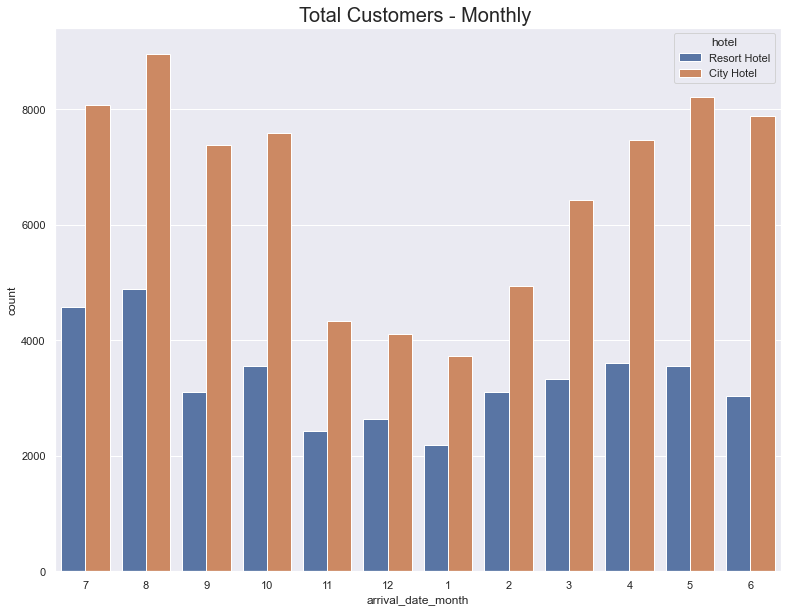

In [57]:
plt.figure(figsize =(13,10))
sns.set(style="darkgrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = df)

<AxesSubplot:xlabel='arrival_date_month', ylabel='is_canceled'>

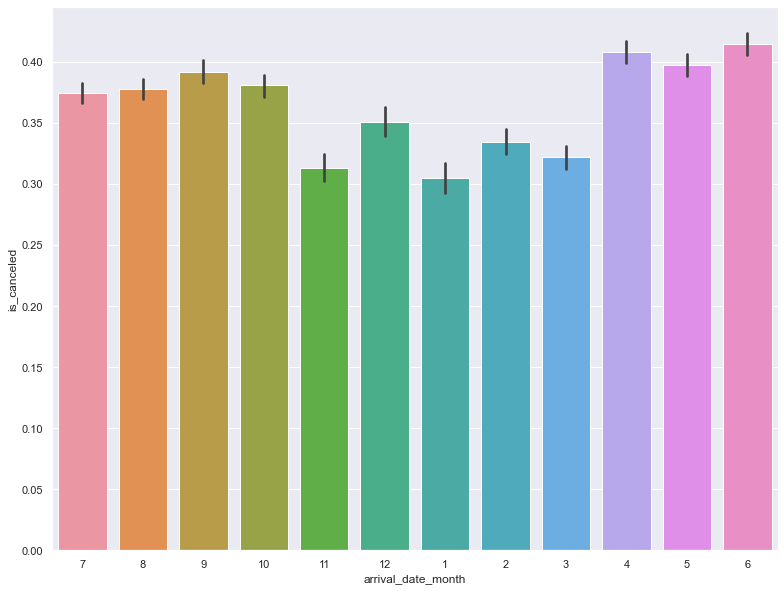

In [58]:
plt.figure(figsize = (13,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', data = df)

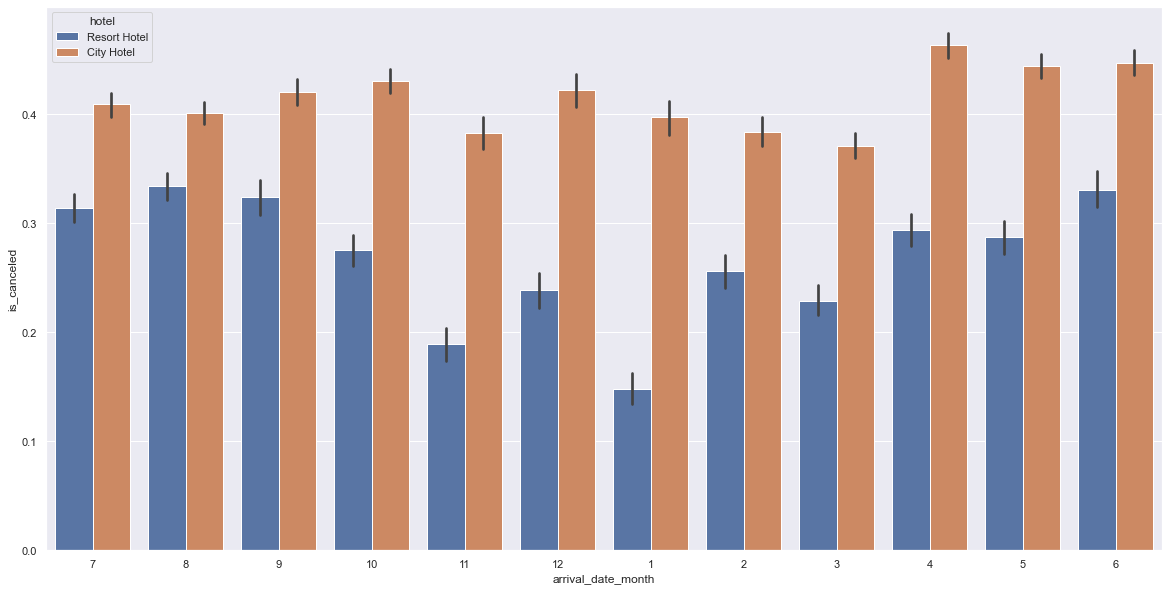

In [59]:
plt.figure(figsize = (20,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', hue = 'hotel', data = df);

Looking at the first graph, it can be seen that the city hotels have more customers in all months. Considering proportionally, resort hotels seem to be a little closer to city hotels in summer.

An important interpretation can be made by examining three graphics together. Fewer customers come in the winter months, so when we look at the cancellation rates, it is quite normal that it appears less in the winter months. The point to be noted on these months is that the cancellation rates of city hotels are almost equal to other months even in winter. The fact that the total cancellation rates of the winter months are low is that the cancellation rates of the resort hotels are low in these months. In short, the possibility of cancellation of resort hotels in winter is very low. This information can be a very important factor when predicting 'is_canceled'.

### Bookings by market segment

In [35]:
# total bookings per market segment (incl. canceled)
segments=df["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

On average, groups get the best prices and Airlines pay approximately twice as much.  
  
What are possible resons for the high prices paid by Airlines?

- Lead time for bookings from Aviation is very short: Mean 4 days vs. 104 days for other bookings.
- Airlines NEED a place for their crews to stay.
- Airline personel usually gets one room per person - more total rooms required compared to families.

### How many bookings were canceled?

In [62]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### Which month have the highest number of cancelations?

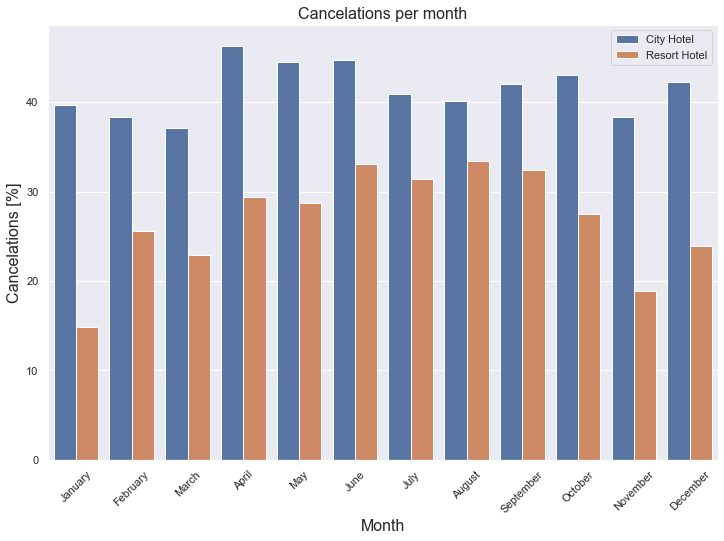

In [63]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

For the City hotel the relative number of cancelations is around 40 % throughout the year.  
For the Resort hotel it is highest in the summer and lowest during the winter. 

## How long do people stay at the hotels?

In [79]:
filter = df1['is_canceled'] == 0
data = df1[filter]
data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
stay = data.groupby(['total_nights', 'hotel']).agg('count').reset_index()
stay = stay.iloc[:, :3]
stay = stay.rename(columns={'is_canceled':'Number of stays'})
stay

/var/folders/ys/qhjkm3dd3r9bs4f8ndl340dw0000gn/T/ipykernel_5287/1754961834.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,total_nights,hotel,Number of stays
0,0,City Hotel,308
1,0,Resort Hotel,372
2,1,City Hotel,9169
3,1,Resort Hotel,6580
4,2,City Hotel,10992
...,...,...,...
63,49,City Hotel,1
64,56,Resort Hotel,1
65,57,City Hotel,1
66,60,Resort Hotel,1


In [83]:
px.bar(data_frame = stay, x = 'total_nights', y = 'Number of stays', color = 'hotel', barmode = 'group')